# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries
from warnings import simplefilter
simplefilter("ignore")

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#Set Matplotlib defaults
plt.style.use('ggplot')
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=16, titlepad=10)
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)
%config InlineBackend.figure_format = 'retina'

# ML libraries
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel
from functions import *

np.random.seed(33)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('azdias.csv', index_col=0, low_memory=False)
customers = pd.read_csv('customers.csv', index_col=0, low_memory=False)

In [3]:
# let's pickle dataframes to speed up data loading
azdias.to_pickle('azdias.pickle')
customers.to_pickle('customers.pickle')

In [2]:
# load in azdias data
azdias = pd.read_pickle('azdias.pickle')

In [3]:
# general information about dataset
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [4]:
# Display first five rows
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
# Number of rows and columns
azdias.shape

(891221, 366)

In [6]:
# Calculate missing values percent by columns
azdias_colnull_percent = 100 * azdias.isnull().sum() / azdias.shape[0]
azdias_colnull_percent = azdias_colnull_percent.sort_values(ascending=False).to_frame()
azdias_colnull_percent.rename(columns={0: 'missing value percent'}, inplace=True)
azdias_colnull_percent.head()

,missing value percent
ALTER_KIND4,99.864792
ALTER_KIND3,99.307691
ALTER_KIND2,96.690047
ALTER_KIND1,90.904837
EXTSEL992,73.399639


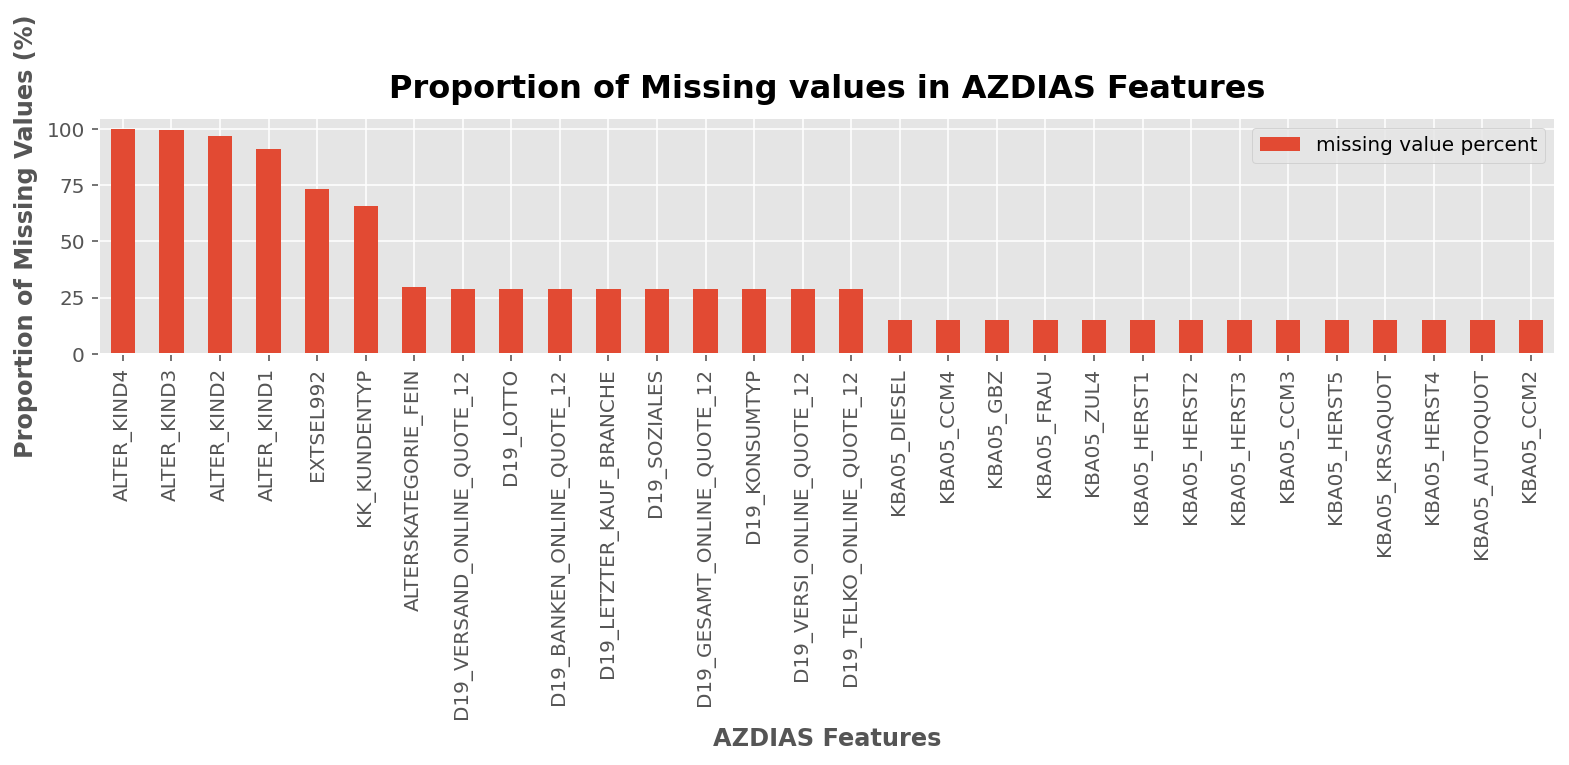

In [7]:
# Visualize most thirty columns that have missing values
azdias_colnull_percent.iloc[:30].plot(kind='bar')
plt.xlabel('AZDIAS Features')
plt.ylabel('Proportion of Missing Values (%)')
plt.title('Proportion of Missing values in AZDIAS Features');

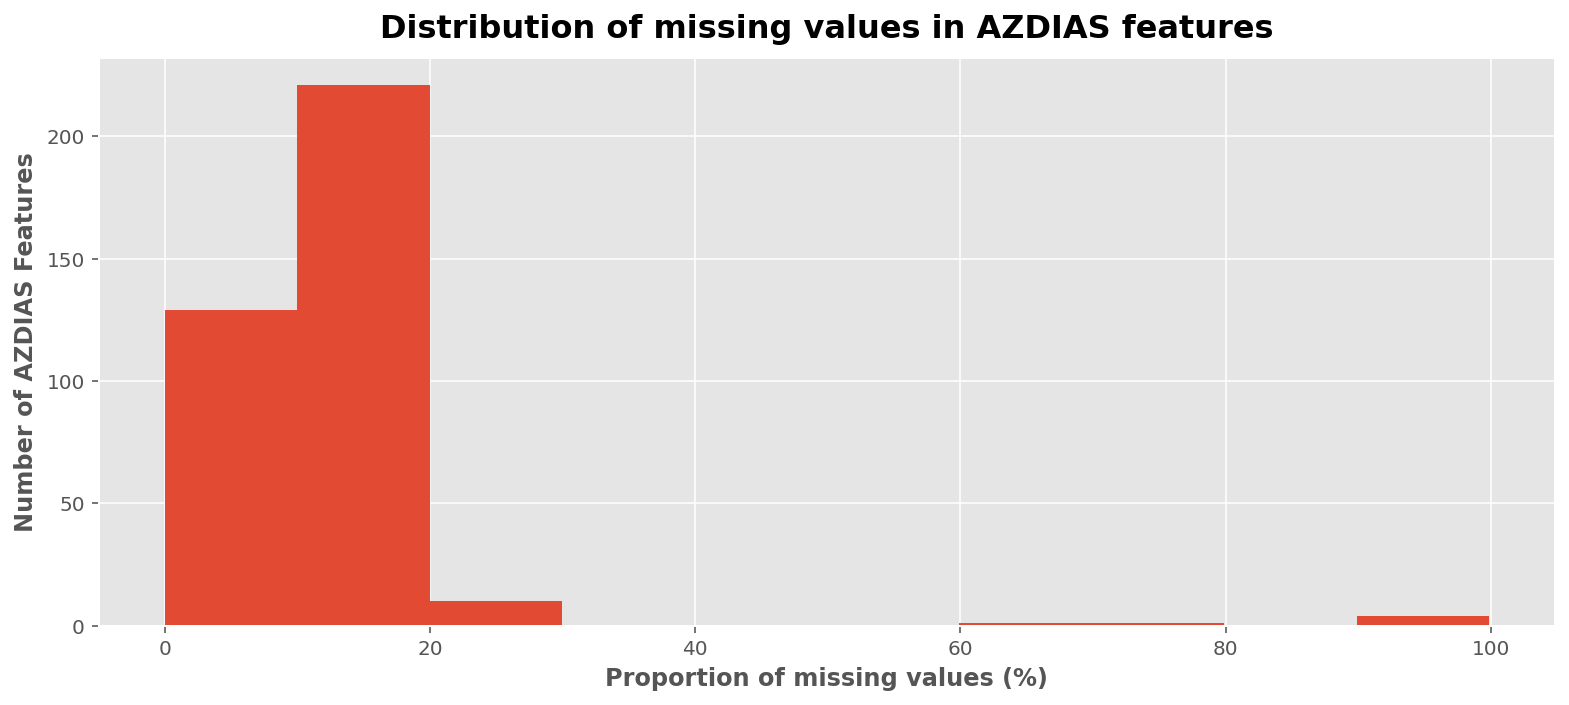

In [8]:
# distribution of columns missing values
plt.hist(azdias_colnull_percent)
plt.xlabel('Proportion of missing values (%)')
plt.ylabel('Number of AZDIAS Features')
plt.title('Distribution of missing values in AZDIAS features');

#### Most columns have missing values percentage less than 20% so we can drop columns that have null values more than 20%.

In [9]:
# Calculate missing values percent by rows
azdias_rownull_percent = 100 * azdias.isnull().mean(axis=1)
azdias_rownull_percent.head()

0    68.852459
1     4.098361
2     1.366120
3     1.912568
4     1.366120
dtype: float64

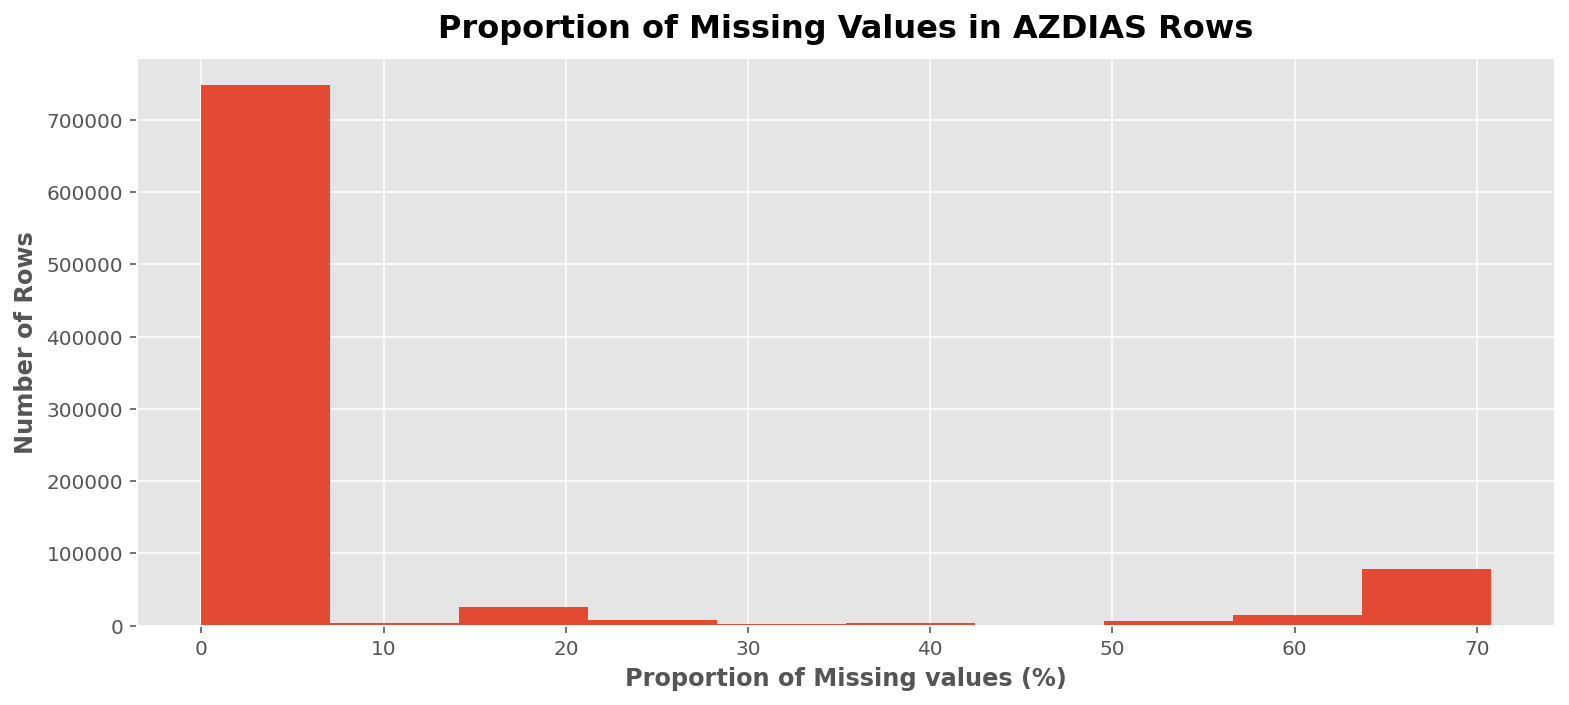

In [10]:
# distribution of row missing values
plt.hist(azdias_rownull_percent)
plt.xlabel('Proportion of Missing values (%)')
plt.ylabel('Number of Rows')
plt.title('Proportion of Missing Values in AZDIAS Rows');

#### Most rows have percentage of missing values less than 10% so we can drop rows that have null values more than 10%.

In [5]:
# clean azdias dataset
azdias_cleaned = clean_dataset(azdias, df_name='azdias')

Cleaning data is in progress please wait 

Converting 'OST_WEST_KZ' column to 1 for 'W' and 0 for 'O'
Dropping most twenty null columns
Dropping Correlated Features
Dropping null rows more than 10%
Cleaning process is done! your data is ready 

New shape after cleaning is: (751328, 326)


In [6]:
azdias_cleaned.to_pickle('azdias_cleaned.pickle')

In [2]:
# load in azdias cleaned data
azdias_cleaned = pd.read_pickle('azdias_cleaned.pickle')

In [3]:
azdias_id = azdias_cleaned.pop('LNR')

In [10]:
# general information about dataset
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 751328 entries, 1 to 891220
Columns: 325 entries, CJT_GESAMTTYP to ALTERSKATEGORIE_GROB
dtypes: float64(238), int64(86), object(1)
memory usage: 1.8+ GB


In [11]:
# Display first five rows
azdias_cleaned.head()

,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0,0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0,0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0,0,0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3,5,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,2.0,5.0,2.0,1.0,5.0,5.0,3.0,3.0,0,0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


In [4]:
# calculate skewness of columns
continuous = azdias_cleaned.select_dtypes(include=float)
skewness = continuous.skew(axis=0, skipna=True, numeric_only=True)

In [5]:
# columns names that have skewness greater than one
skewd_cols = skewness[abs(skewness) >1].index

In [6]:
# Transform-impute-standard scaler Pipeline for skewd_cols
skew_pipeline = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),
    ('log_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('log_scale', StandardScaler())
])

In [7]:
# columns that have two unique values
binary_cols = []
for column in azdias_cleaned.select_dtypes(['float64', 'int64']).columns:
    num_unique = azdias_cleaned[column].dropna().nunique()
    if num_unique == 2:
        binary_cols.append(column)

binary_cols

['DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KONSUMZELLE',
 'OST_WEST_KZ',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'ANREDE_KZ']

In [8]:
# impute pipeline for binary columns
binary_pipeline = Pipeline([('bin_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

In [9]:
# catageory columns in the dataset
categorical_cols = azdias_cleaned.select_dtypes(['object']).columns
[print(f"Column '{col}' has: {azdias_cleaned[col].nunique()} unique values") for col in categorical_cols];

Column 'D19_LETZTER_KAUF_BRANCHE' has: 35 unique values


In [10]:
# impute-one hot encoder pipeline for categorical columns
categorical_pipeline = Pipeline([
    ('bin_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))
])

In [11]:
# numerical columns after we excluded skewd and binary columns
numerical_cols = list(set(azdias_cleaned.columns) - set(skewd_cols) - set(binary_cols) - set(categorical_cols))

In [12]:
# impute-standard scaler pipeline for numerical columns
numerical_pipeline = Pipeline([
    ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('num_scale', StandardScaler())
])

In [13]:
# Combine pipelines to aplly for all datasets we need
transformers = [('skewed', skew_pipeline, skewd_cols), 
                ('numerical', numerical_pipeline, numerical_cols), 
                ('binary', binary_pipeline, binary_cols), 
                ('categorical', categorical_pipeline, categorical_cols)]

In [14]:
# create column_transformer object
column_transformer = ColumnTransformer(transformers=transformers)

In [23]:
# transformer azdias dataset
transformed_azdias = column_transformer.fit_transform(azdias_cleaned)

In [24]:
# Number of rows and columns after transformation
transformed_azdias.shape

(751328, 365)

In [25]:
# Get column names from one hot encoded features
dummy_cols = list(column_transformer.transformers_[3][1].named_steps['OneHotEncoder'].get_feature_names(categorical_cols))

In [26]:
# Create list of column names for transformed dataframe
columns_names = list(skewd_cols) + numerical_cols + binary_cols + dummy_cols

In [27]:
# Create transformed dataframe
azdias_modified = pd.DataFrame(transformed_azdias, columns=[columns_names])

In [28]:
# display first five rows
azdias_modified.head()

,D19_BANKEN_ONLINE_QUOTE_12,D19_LOTTO,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSI_ONLINE_QUOTE_12,DSL_FLAG,GEBAEUDETYP,HH_DELTA_FLAG,KBA05_ALTER1,KBA05_ALTER2,...,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
0,-0.238643,-0.465563,-0.417269,-0.030732,-0.044755,0.106249,1.767625,-0.314599,0.757439,0.760368,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.238643,-0.465563,-0.417269,-0.030732,-0.044755,0.106249,-0.777884,-0.314599,0.195373,0.039958,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.238643,-0.465563,-0.417269,-0.030732,-0.044755,0.106249,-0.777884,-0.314599,0.195373,1.348986,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4.209130,-0.465563,-0.417269,-0.030732,-0.044755,0.106249,-0.777884,-0.314599,-1.951068,0.760368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.238643,-0.465563,2.624890,-0.030732,-0.044755,0.106249,-0.777884,-0.314599,-1.951068,0.760368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Check if all features are numerical
azdias_modified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751328 entries, 0 to 751327
Columns: 365 entries, ('D19_BANKEN_ONLINE_QUOTE_12',) to ('D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST',)
dtypes: float64(365)
memory usage: 2.0 GB


In [30]:
# save modified azdias data
azdias_modified.to_pickle('azdias_modified.pickle')

### Now let's move to customer dataset

In [19]:
# load in customers data
customers = pd.read_pickle('customers.pickle')

In [34]:
# Display first five rows
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [35]:
# Number of rows and columns
customers.shape

(191652, 369)

In [36]:
# general information about dataset
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 541.0+ MB


In [37]:
# Summary statistics
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [38]:
# Calculate missing values percent by rows
customers_rownull_percent = 100 * customers.isnull().mean(axis=1)

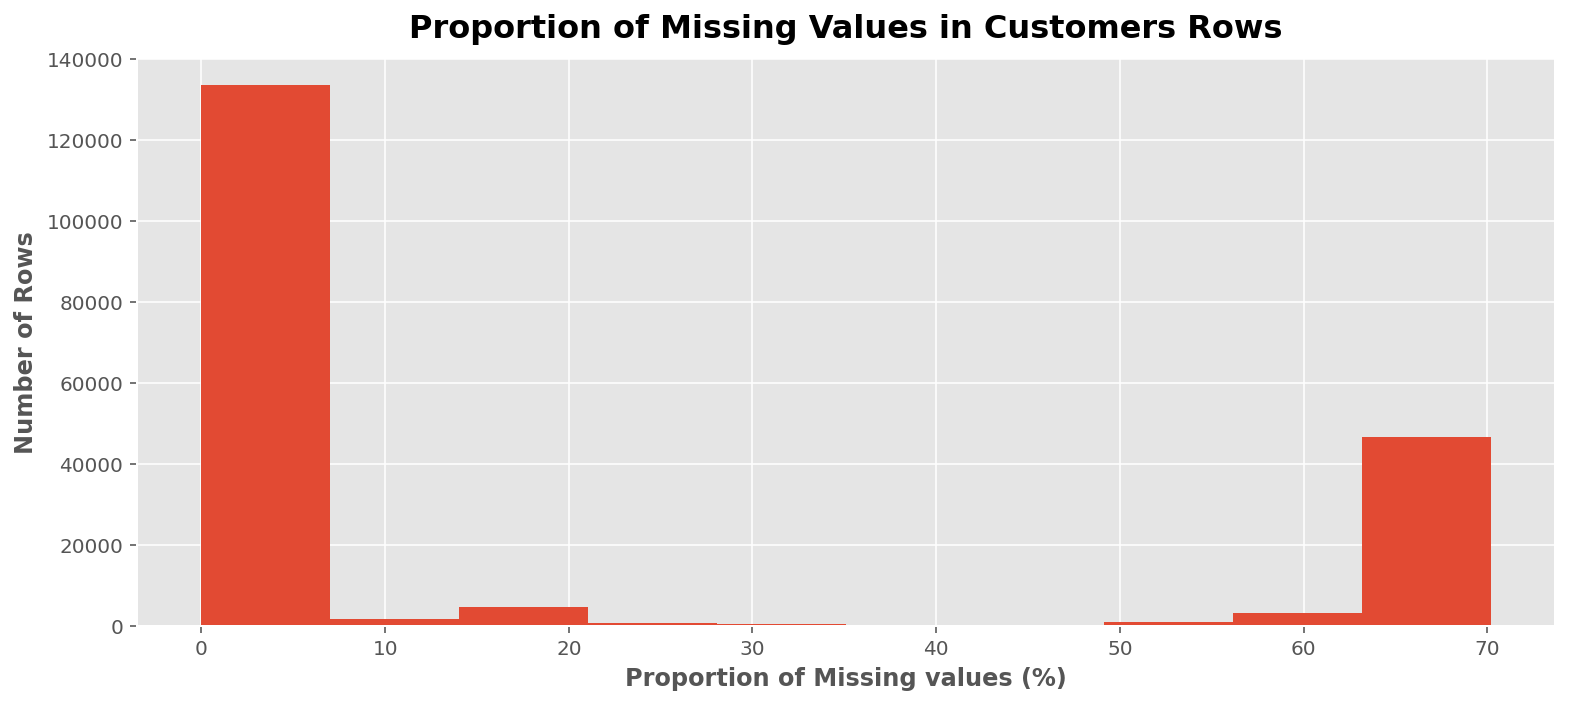

In [39]:
# distribution of row missing values
plt.hist(customers_rownull_percent)
plt.xlabel('Proportion of Missing values (%)')
plt.ylabel('Number of Rows')
plt.title('Proportion of Missing Values in Customers Rows');

#### Most rows have percentage of missing values less than 10% so we can drop rows that have null values more than 10%.

In [20]:
# clean customers dataset
customers_cleaned = clean_dataset(customers, df_name='customers')

Cleaning data is in progress please wait 

Converting 'OST_WEST_KZ' column to 1 for 'W' and 0 for 'O'
Dropping most twenty null columns
Dropping Correlated Features
Dropping null rows more than 10%
Cleaning process is done! your data is ready 

New shape after cleaning is: (135144, 329)


In [21]:
customers_cleaned.to_pickle('customers_cleaned.pickle')

In [15]:
customers_cleaned = pd.read_pickle('customers_cleaned.pickle')

In [16]:
customers_id = customers_cleaned.pop('LNR')

In [17]:
# find differences between features in customers and azdias
customers_extra = set(customers_cleaned.columns) - set(azdias_cleaned.columns)
print(f"Number of features in customers not in azdias: {len(customers_extra)}", '\n')
customers_extra

Number of features in customers not in azdias: 3 



{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [18]:
# drop extra columns
customers_cleaned.drop(customers_extra, axis=1, inplace=True)

In [19]:
# new shape of customers dataset
customers_cleaned.shape

(135144, 325)

In [44]:
# load in DIAS Attributes
attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=1)
attributes = attributes.iloc[:, 1:]
# filling missing values
attributes.iloc[:,:-1].fillna(method='ffill', inplace=True)
attributes.iloc[:,-1].fillna("no_meaning_available", inplace=True)
# Display first five rows
attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [45]:
# Number of rows and columns
attributes.shape

(2258, 4)

In [46]:
# missing values count
attributes.isnull().sum()

Attribute      0
Description    0
Value          0
Meaning        0
dtype: int64

In [27]:
# load in DIAS Information Levels
information = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', skiprows=1)
information = information.iloc[:, 1:]
# filling missing values
information.iloc[:,0].fillna(method='ffill', inplace=True)
information.iloc[:,0].fillna(method='bfill', inplace=True)
information.iloc[:,-1].fillna('No_notes', inplace=True)
# Display first five rows
information.head()

,Information level,Attribute,Description,Additional notes
0,Person,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,No_notes
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [28]:
# Number of rows and columns
information.shape

(313, 4)

In [29]:
# missing values count
information.isna().sum()

Information level    0
Attribute            0
Description          0
Additional notes     0
dtype: int64

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [3]:
azdias_modified = pd.read_pickle('azdias_modified.pickle')

In [52]:
# Fit PCA object to modified azdias dataset
pca = PCA().fit(azdias_modified)

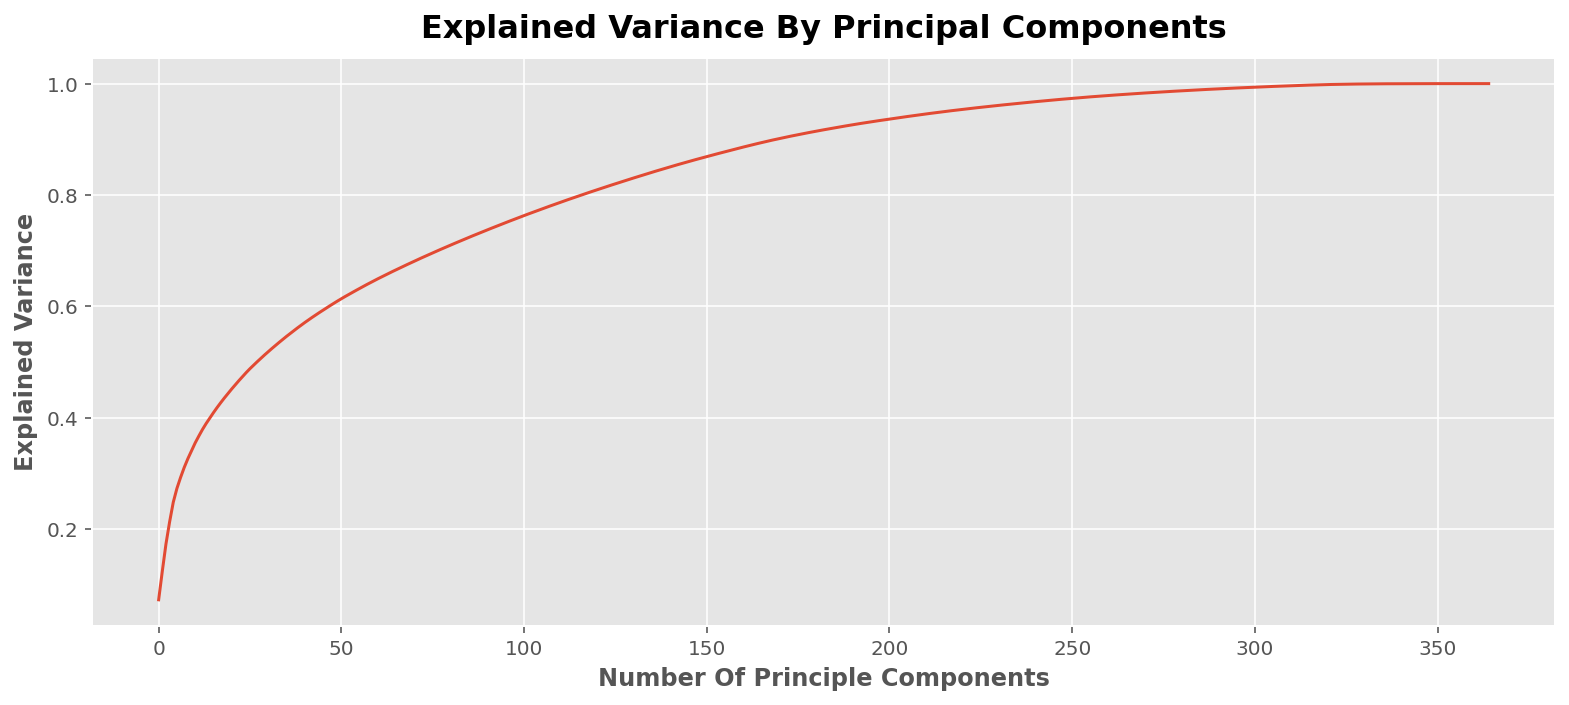

In [53]:
# plot explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance By Principal Components')
plt.xlabel('Number Of Principle Components')
plt.ylabel('Explained Variance')
plt.show();

In [54]:
# calculate number of components percentage that explain 95% of Variance to use it in new pca
cum_variance = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_), columns=['cumulative_variance'], 
                            index=np.arange(1, azdias_modified.shape[1]+1))

print(f"{cum_variance.loc[cum_variance['cumulative_variance'] >0.95].index[0]} components explain 95% of the variance")

217 components explain 95% of the variance


In [53]:
# Fit PCA object to modified azdias dataset with 217 components
pca = PCA(n_components=217).fit(azdias_modified)

In [54]:
# create azdias_reduced dataframe with PCA
azdias_reduced = pd.DataFrame(pca.transform(azdias_modified))

In [51]:
azdias_reduced.to_pickle('azdias_reduced.pickle')

In [55]:
print(f"The First Five Components Explain {np.around(100* np.sum(pca.explained_variance_ratio_[:5]), 2)}% Of The Variance.")

The First Five Components Explain 24.81% Of The Variance.


In [56]:
# create weights dataframe for every component relative to population features
weights = pd.DataFrame(index=azdias_modified.columns, columns=['weight' + '_' + str(i+1) for i in range(len(pca.components_))])
for i in range(len(pca.components_)):
    weights.iloc[:, i] = np.around(pca.components_[i], 2)

In [57]:
# display first five rows
weights.head()

,weight_1,weight_2,weight_3,weight_4,weight_5,weight_6,weight_7,weight_8,weight_9,weight_10,...,weight_208,weight_209,weight_210,weight_211,weight_212,weight_213,weight_214,weight_215,weight_216,weight_217
D19_BANKEN_ONLINE_QUOTE_12,0.03,-0.05,0.06,0.00,0.07,-0.02,0.01,0.01,-0.01,-0.10,...,-0.09,-0.15,-0.01,0.05,0.06,0.06,-0.01,-0.04,0.02,-0.06
D19_LOTTO,0.06,-0.02,-0.01,-0.03,0.06,-0.01,0.01,0.00,0.01,0.02,...,-0.00,-0.01,-0.00,0.00,0.01,0.00,0.01,-0.01,-0.00,-0.02
D19_SOZIALES,0.07,0.01,-0.01,-0.04,0.07,-0.02,0.01,-0.01,0.01,0.03,...,0.00,0.01,0.00,-0.00,-0.00,-0.01,0.01,0.00,0.00,0.02
D19_TELKO_ONLINE_QUOTE_12,0.01,-0.01,0.00,-0.00,0.01,-0.00,0.00,0.00,-0.00,-0.01,...,-0.11,-0.26,-0.08,-0.17,-0.14,-0.25,-0.18,-0.12,-0.01,0.07
D19_VERSI_ONLINE_QUOTE_12,0.01,-0.01,0.01,0.00,0.01,-0.00,0.01,0.00,0.00,-0.01,...,0.00,0.00,-0.02,0.01,0.02,0.04,-0.04,-0.01,-0.03,-0.08


In [58]:
print(f"The First Component Explains {np.around(100* np.sum(pca.explained_variance_ratio_[0]), 2)}% Of The Variance.")
weights['weight_1'].sort_values(ascending=False)[:5]

The First Component Explains 7.29% Of The Variance.


MOBI_REGIO        0.15
LP_STATUS_FEIN    0.14
KBA05_ANTG1       0.14
KBA13_ANTG1       0.14
MOBI_RASTER       0.14
Name: weight_1, dtype: float64

#### from here we can analyze every pca component and how features contribute in weights.

In [2]:
azdias_reduced = pd.read_pickle('azdias_reduced.pickle')

### Cluster population dataset by KMeans cluster

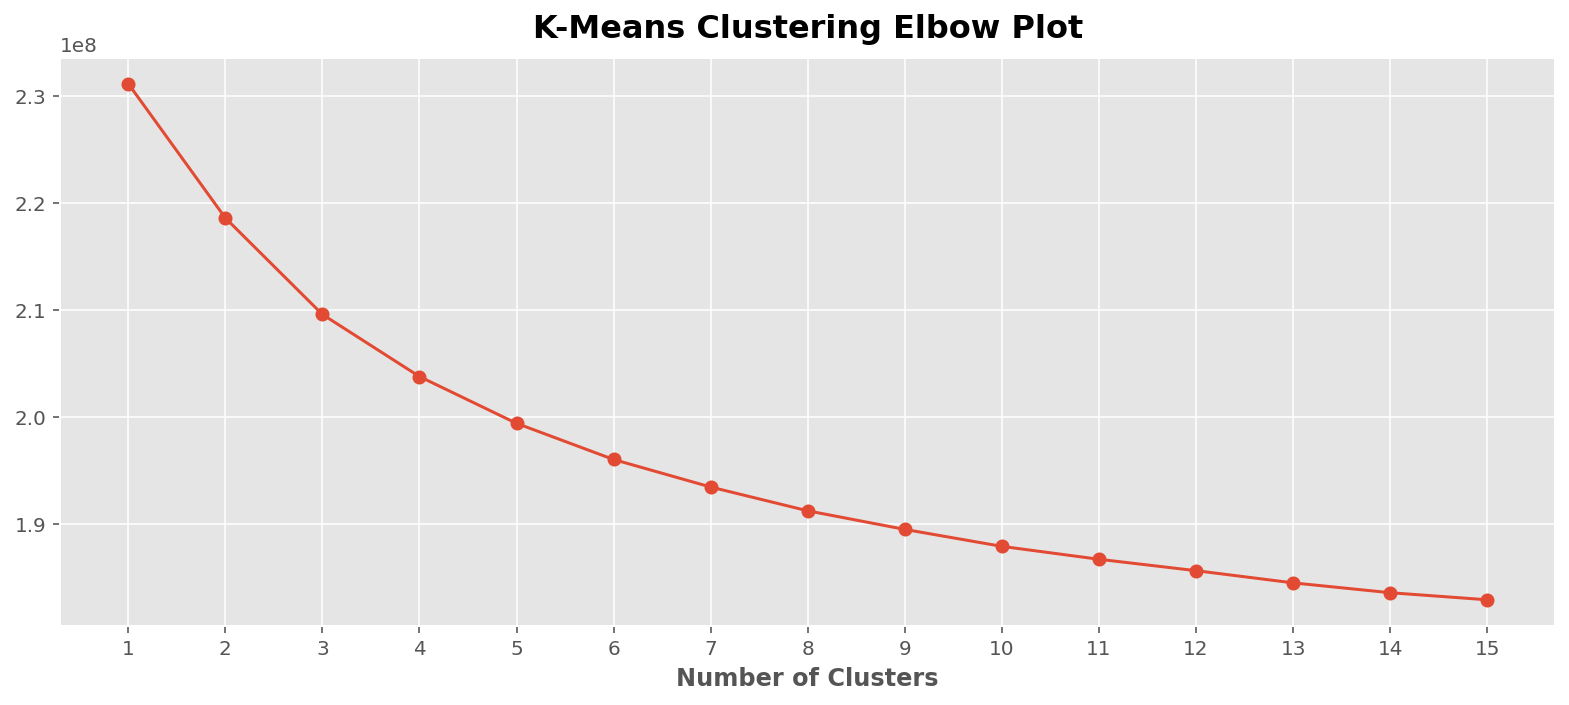

In [50]:
# cluster the population dataset by applying k-means cluster algorithm
results = []
for n in range(1, 16):
    kmeans = KMeans(n_clusters=n, init='k-means++', random_state=0).fit(azdias_reduced)
    results.append([n, kmeans.inertia_])

results = pd.DataFrame(data=results, columns=['Number of clusters', 'Intertia']).set_index('Number of clusters')

# plot k-means and determine number of clusters by elbow technique
plt.plot(results, '-o')
plt.title('K-Means Clustering Elbow Plot')
plt.xlabel("Number of Clusters")
plt.xticks(results.index)
plt.show();

### we'll choose 5 clusters as the plot seems to show elbow at this point

In [37]:
# PCA and K-Means parameters
pca_components = 217
kmeans_clusters = 5

In [38]:
# Create cluster pipeline
cluster_pipeline = Pipeline([
    ('transform', column_transformer),
    ('reduce', PCA(n_components=pca_components)),
    ('cluster', KMeans(n_clusters=kmeans_clusters, init='k-means++', random_state=0))
])

In [39]:
# create clustered population dataframe
cluster_pipeline.fit(azdias_cleaned)
azdias_clustered = pd.DataFrame(cluster_pipeline.predict(azdias_cleaned), columns=['Cluster'])

In [40]:
# Create clustered customers dataframe
customers_clustered = pd.DataFrame(cluster_pipeline.predict(customers_cleaned), columns=['Cluster'])

In [41]:
azdias_clustered.to_pickle('azdias_clustered.pickle')
customers_clustered.to_pickle('customers_clustered.pickle')

In [23]:
azdias_clustered = pd.read_pickle('azdias_clustered.pickle')
customers_clustered = pd.read_pickle('customers_clustered.pickle')

In [42]:
# clusters size in azdias dataset
population_clusters = azdias_clustered['Cluster'].value_counts().sort_index()
population_clusters

0    170947
1    219595
2    104980
3     14042
4    241764
Name: Cluster, dtype: int64

In [43]:
# clusters size in customers dataset
customer_clusters = customers_clustered['Cluster'].value_counts().sort_index()
customer_clusters

0    49926
1    11426
2     6761
3      898
4    66133
Name: Cluster, dtype: int64

In [54]:
# add both dataframes
clusters = pd.concat([population_clusters, customer_clusters], axis=1).reset_index()
clusters.columns = ['cluster', 'population_count', 'customers_count']

In [55]:
# Calculate shares of each cluster
clusters['population_share'] = clusters['population_count'] / clusters['population_count'].sum() *100
clusters['customers_share'] = clusters['customers_count'] / clusters['customers_count'].sum() *100
clusters['diff_share'] = clusters['customers_share'] - clusters['population_share']

In [56]:
clusters.to_pickle('clusters.pickle')

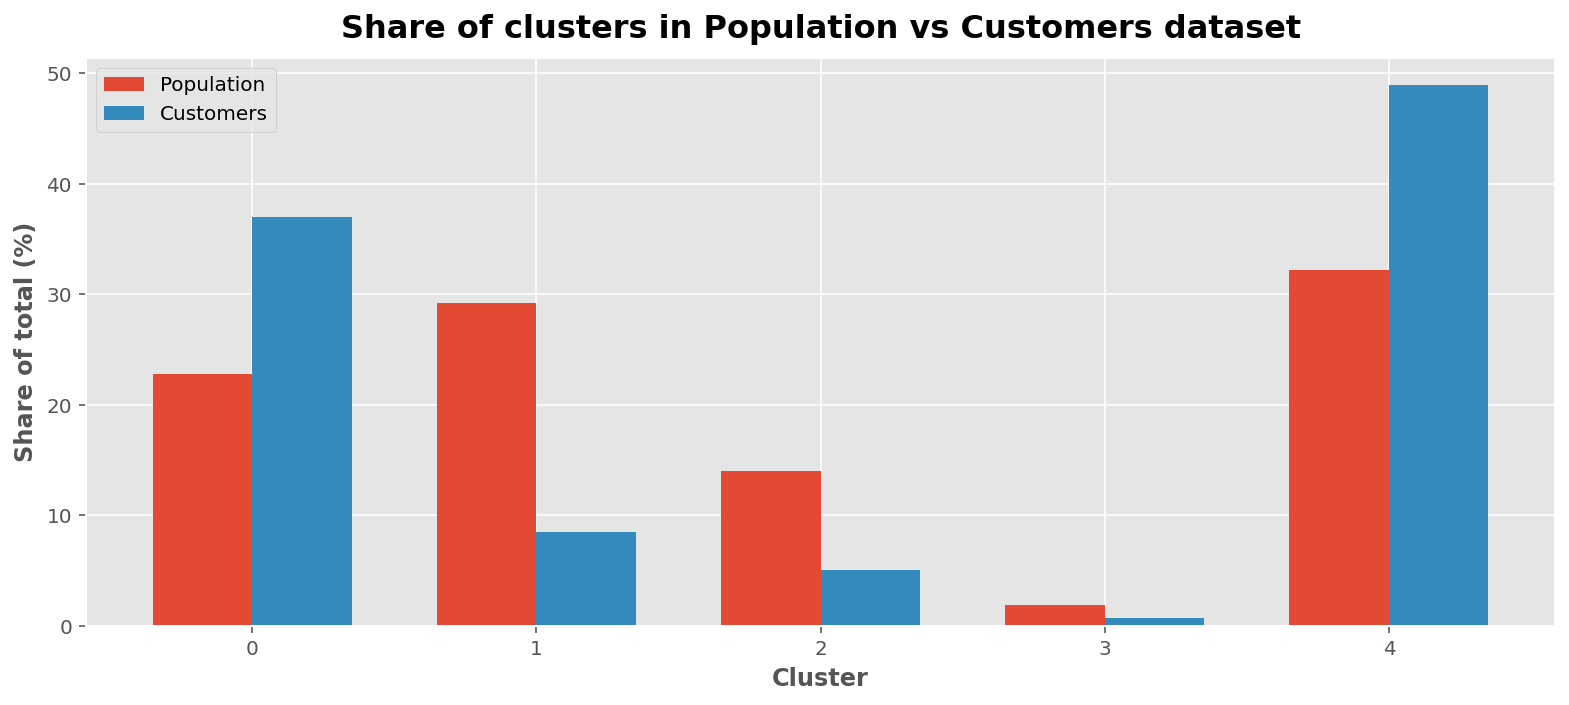

In [57]:
# Plot clusters shares
fig, ax = plt.subplots()

ind = np.arange(kmeans_clusters)
width = 0.35

p1 = ax.bar(ind, clusters['population_share'], width, bottom=0)
p2 = ax.bar(ind + width, clusters['customers_share'], width, bottom=0)

ax.set_title('Share of clusters in Population vs Customers dataset')
ax.set_ylabel('Share of total (%)')
ax.set_xlabel('Cluster')

ax.set_xticks(ind + width/2)
ax.set_xticklabels(clusters['cluster'])
ax.legend((p1[0], p2[0]), ('Population', 'Customers'));

### The plot shows how clusters are distributed across both datasets. 

### People in  Clusters 0 and 4 are more likely to be our future customers and marketing campaign should focus on these groups. While clusters 1, 2 and 3 seems to be less interesting.

In [59]:
# get index of best candidates
best_clusters = [0, 4]
candidates = azdias_clustered.query(f'Cluster in {best_clusters}').index

In [60]:
# add ID column to azdias dataset
azdias_cleaned['ID'] = azdias_id

In [61]:
# candidates ID
candidates_id = azdias_cleaned.iloc[candidates, -1]
candidates_id.head()

2    910225
3    910226
4    910241
5    910244
7    910261
Name: ID, dtype: category
Categories (891221, int64): [191653, 191654, 191655, 191656, ..., 1082870, 1082871, 1082872, 1082873]

In [62]:
# Number of our candidates
len(candidates_id)

412711

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [67]:
# load mailout_train dataset
mailout_train = pd.read_csv('mailout_train.csv', index_col=0)

In [68]:
# display first five rows
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [69]:
# Number of rows and columns
mailout_train.shape

(42962, 367)

In [70]:
# clean train dataset with clean_dataset function
mailout_train = clean_dataset(mailout_train, df_name='mailout_train')

Cleaning data is in progress please wait 

Converting 'OST_WEST_KZ' column to 1 for 'W' and 0 for 'O'
Dropping most twenty null columns
Dropping Correlated Features
Dropping null rows more than 10%
Cleaning process is done! your data is ready 

New shape after cleaning is: (34214, 326)


In [71]:
mailout_train.to_pickle('mailout_train_cleaned.pickle')

In [24]:
mailout_train = pd.read_pickle('mailout_train_cleaned.pickle')

In [73]:
# transform data with column_transformer
transformed_mailout_train = column_transformer.fit_transform(mailout_train)

In [74]:
# Create transformed dataframe
mailout_train_modified = pd.DataFrame(transformed_mailout_train, columns=[columns_names])

In [75]:
# Number of rows and columns after transforming
mailout_train_modified.shape

(34214, 365)

In [76]:
# reset index in mailout_train and mailout_train_modified datasets
mailout_train.reset_index(inplace=True)
mailout_train_modified.reset_index(inplace=True)

In [77]:
# append RESPONSE column to modified mailout_train dataset
mailout_train_modified['RESPONSE'] = mailout_train['RESPONSE']

In [78]:
# check shape
mailout_train_modified.shape

(34214, 367)

In [79]:
mailout_train_modified.to_pickle('mailout_train_modified.pickle')

In [2]:
mailout_train_modified = pd.read_pickle('mailout_train_modified.pickle')

In [7]:
mailout_train_modified.to_csv('mailout_train_modified.csv')

In [80]:
mailout_train_modified.drop('index', axis=1, inplace=True)

In [81]:
mailout_train_modified.head()

,D19_BANKEN_ONLINE_QUOTE_12,D19_LOTTO,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSI_ONLINE_QUOTE_12,DSL_FLAG,GEBAEUDETYP,HH_DELTA_FLAG,KBA05_ALTER1,KBA05_ALTER2,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,RESPONSE
0,-0.213404,-0.858198,-0.211025,-0.032372,-0.040319,0.1064,0.544136,-0.368575,-0.455852,0.232106,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,-0.213404,-0.858198,1.629639,-0.032372,-0.040319,0.1064,-0.686542,-0.368575,0.954128,-2.075424,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.213404,-0.858198,0.468309,-0.032372,-0.040319,0.1064,0.033359,-0.368575,-0.455852,0.232106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,-0.213404,1.187769,-0.211025,-0.032372,-0.040319,0.1064,-0.686542,-0.368575,0.368934,0.232106,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,-0.213404,-0.858198,-0.211025,-0.032372,-0.040319,0.1064,0.544136,-0.368575,-0.455852,-2.075424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [94]:
# create X features and y target variables
X = mailout_train_modified.drop('RESPONSE', axis=1)
y = mailout_train_modified['RESPONSE'].values

In [89]:
# supervised classification models
models = {'LogisticRegressionModel': LogisticRegression(),
          'RandomForestClassifier': RandomForestClassifier(), 
          'AdaBoostClassifier': AdaBoostClassifier(), 
          'SGDClassifier': SGDClassifier(loss="modified_huber"),
          'GradientBoostingClassifier': GradientBoostingClassifier()}

LogisticRegression()
New X Shape is  (34214, 122)


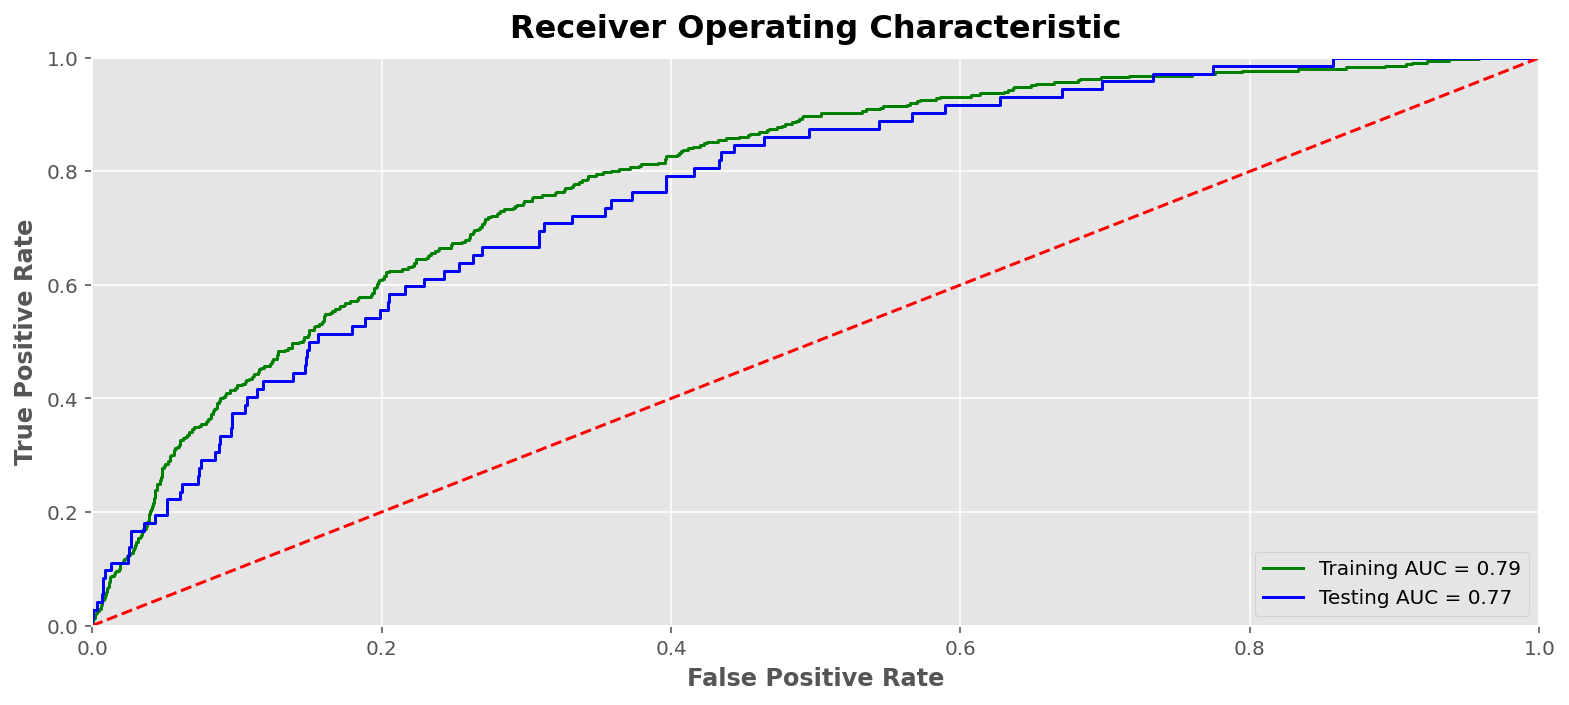

----------------------------------------
RandomForestClassifier()
New X Shape is  (34214, 204)


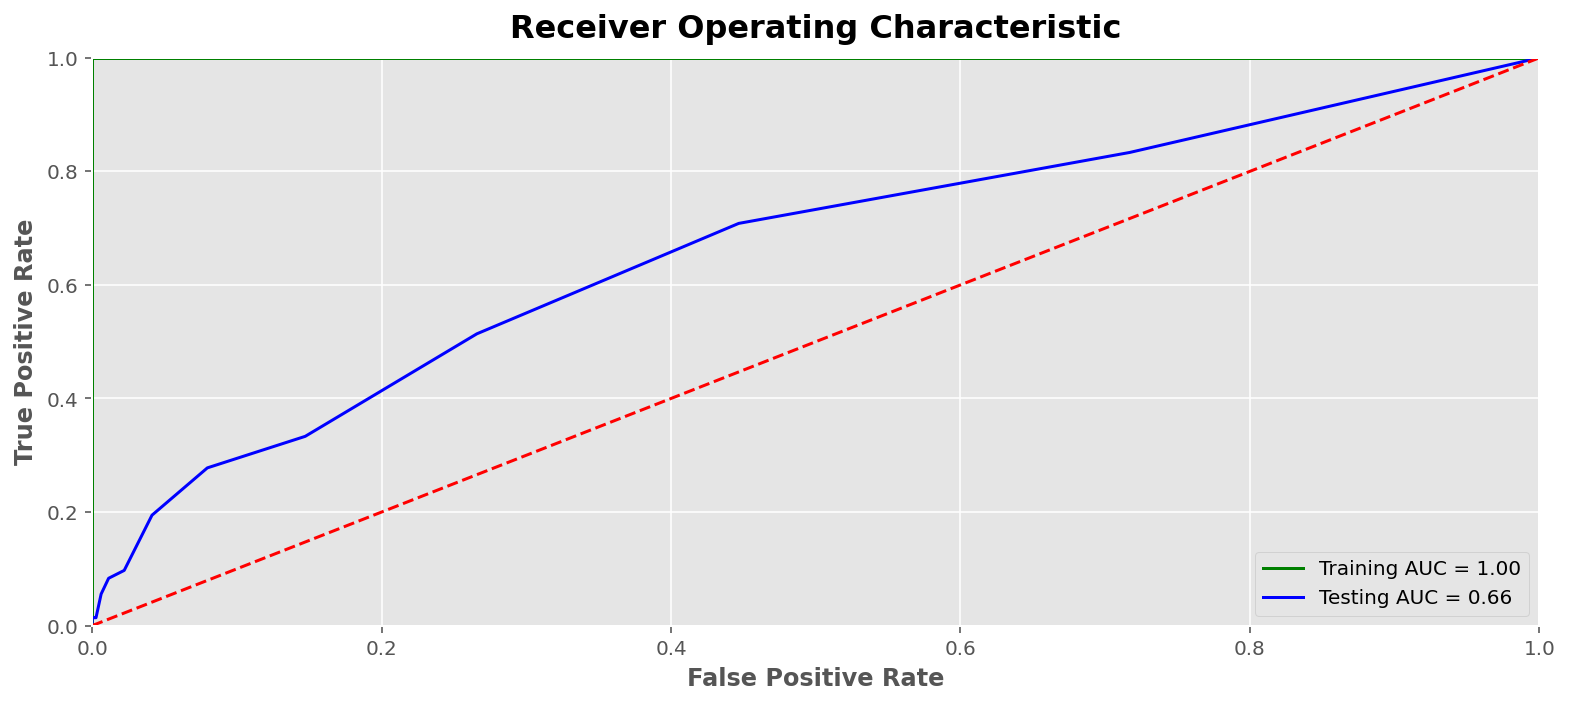

----------------------------------------
AdaBoostClassifier()
New X Shape is  (34214, 46)


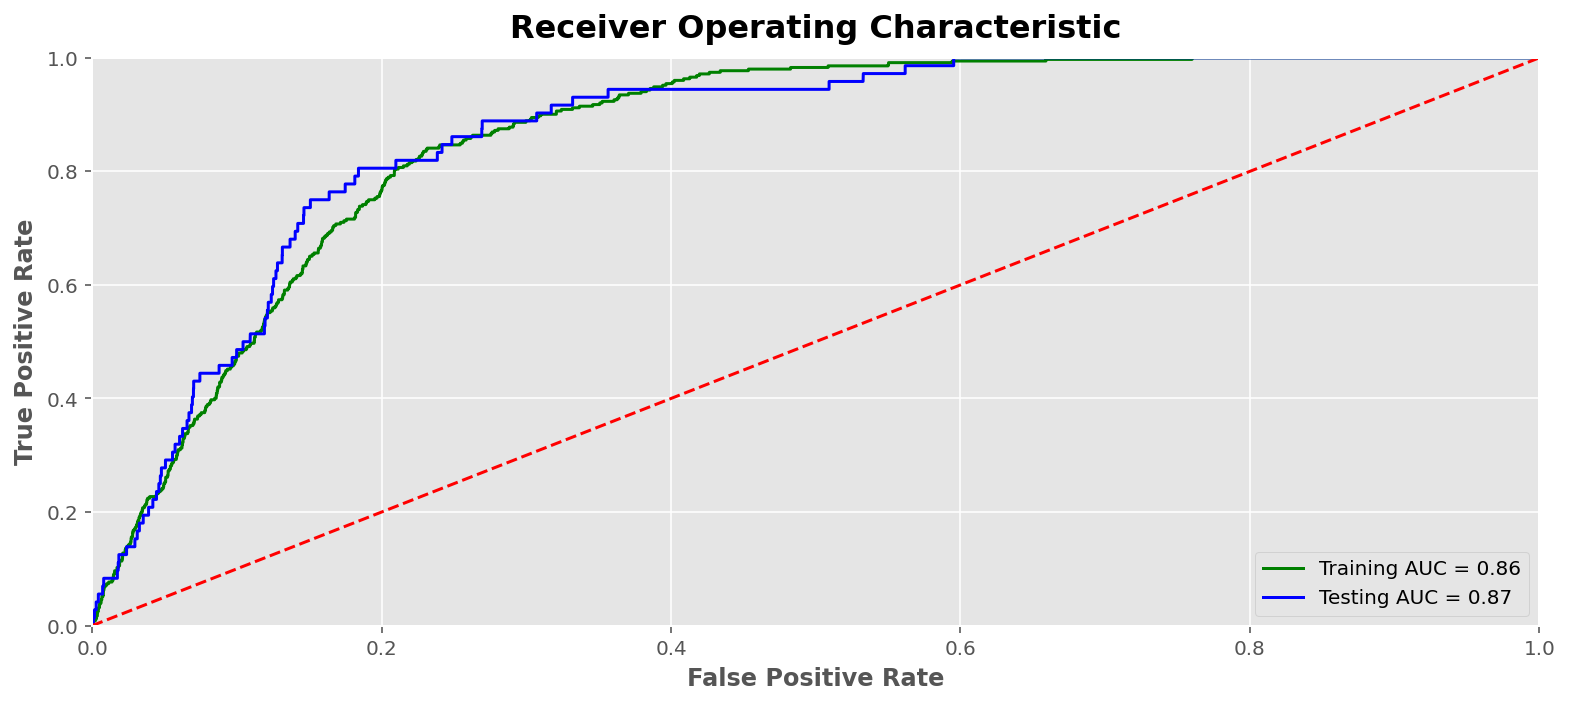

----------------------------------------
SGDClassifier(loss='modified_huber')
New X Shape is  (34214, 56)


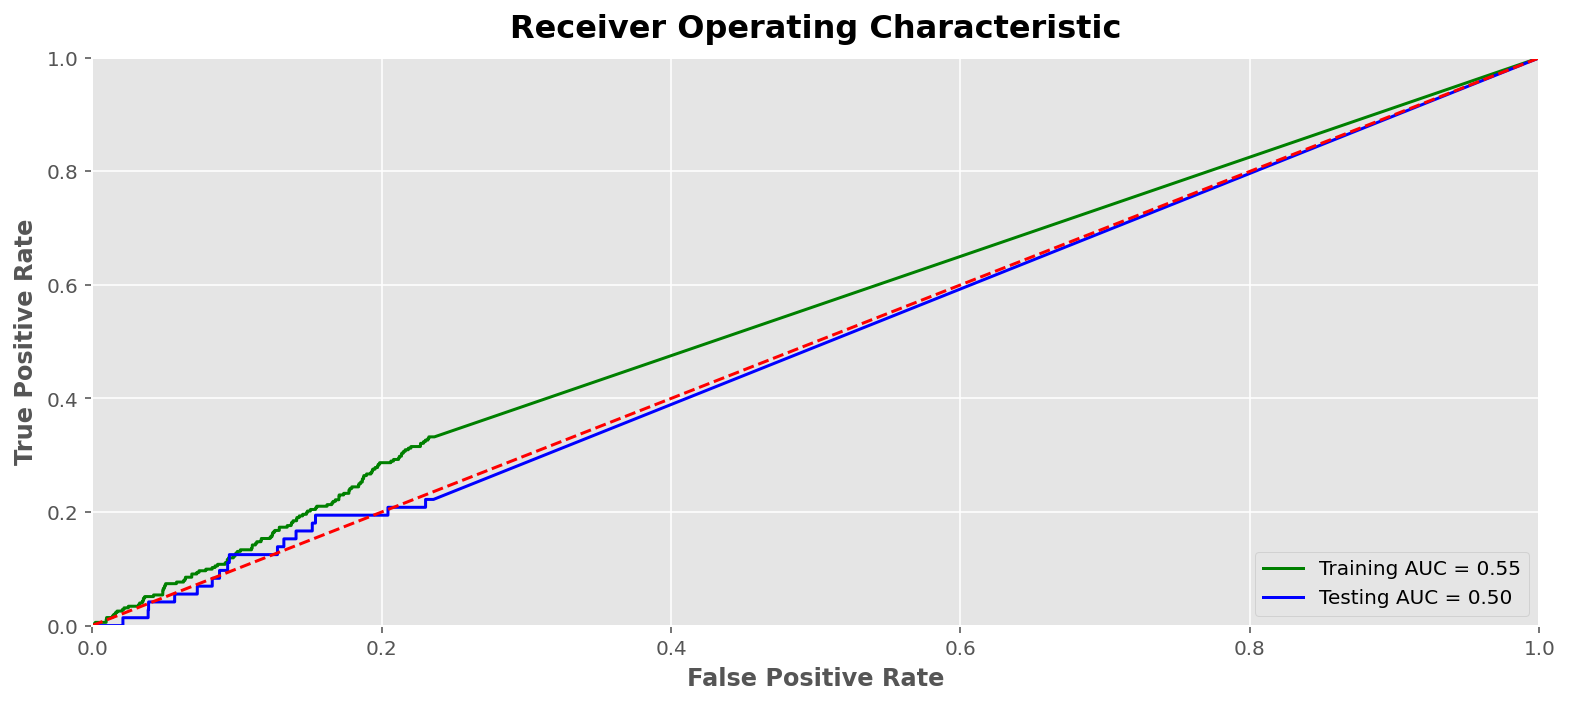

----------------------------------------
GradientBoostingClassifier()
New X Shape is  (34214, 91)


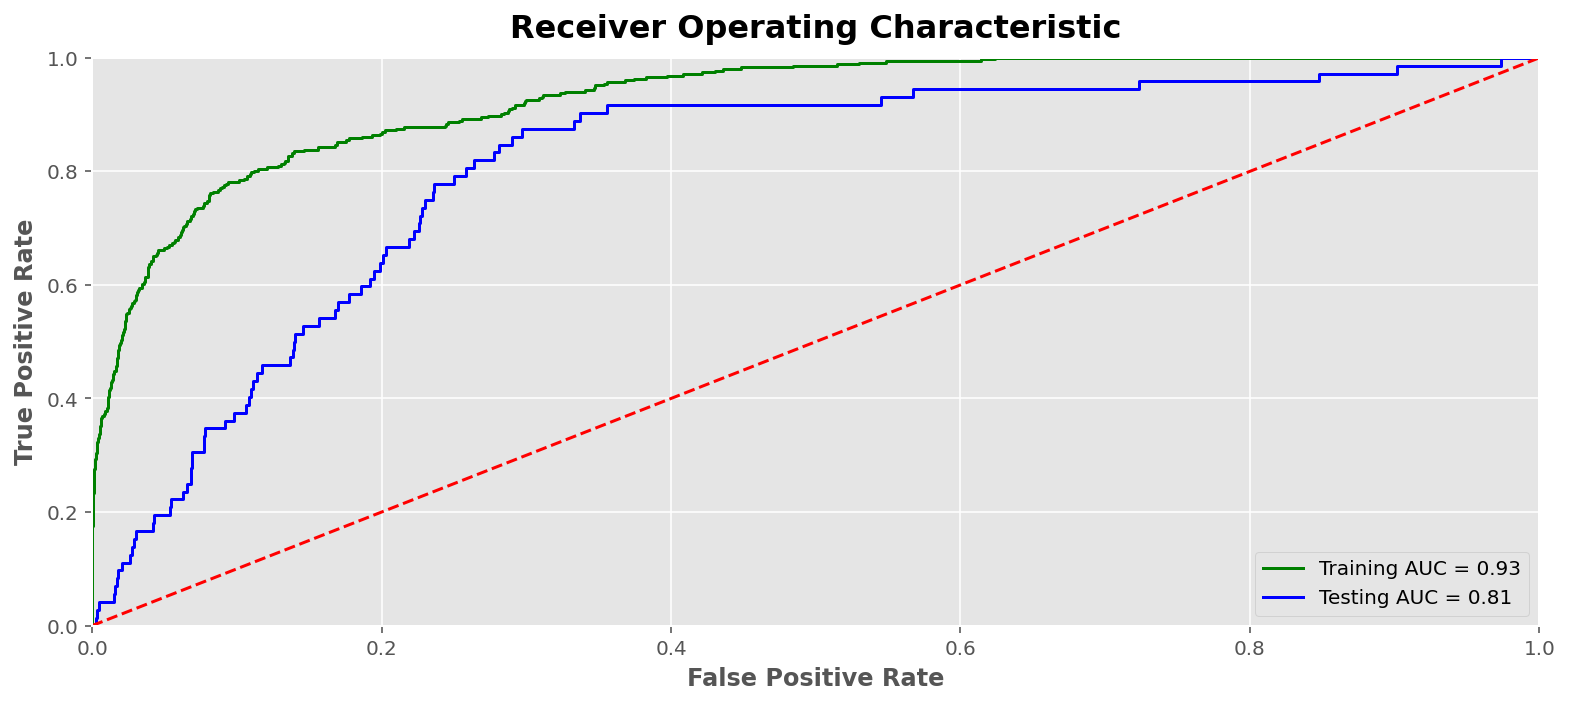

----------------------------------------


In [90]:
# determine best model by evaluate function
for model in models.values():
    evaluate(model, X, y)

#### best model is AdaBoostClassifier with just 46 features

In [95]:
AdaBoostClassifierModel = AdaBoostClassifier()

FeatureSelection = SelectFromModel(estimator=AdaBoostClassifierModel, max_features=None)
X_ada = FeatureSelection.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_ada, y, test_size=0.2, random_state=33)
AdaBoostClassifierModel.fit(X_train, y_train)

y_pred = AdaBoostClassifierModel.predict_proba(X_test)[:,1]

ROCAUCScore = roc_auc_score(y_test, y_pred)
print('ROCAUC Score : ', ROCAUCScore)

ROCAUC Score :  0.8653366481235334


## predict with autogluon

In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [3]:
data = TabularDataset('mailout_train_modified.csv')
data = data.iloc[:, 2:]
data.head()

,D19_BANKEN_ONLINE_QUOTE_12,D19_LOTTO,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSI_ONLINE_QUOTE_12,DSL_FLAG,GEBAEUDETYP,HH_DELTA_FLAG,KBA05_ALTER1,KBA05_ALTER2,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,RESPONSE
0,-0.213404,-0.858198,-0.211025,-0.032372,-0.040319,0.1064,0.544136,-0.368575,-0.455852,0.232106,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,-0.213404,-0.858198,1.629639,-0.032372,-0.040319,0.1064,-0.686542,-0.368575,0.954128,-2.075424,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.213404,-0.858198,0.468309,-0.032372,-0.040319,0.1064,0.033359,-0.368575,-0.455852,0.232106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,-0.213404,1.187769,-0.211025,-0.032372,-0.040319,0.1064,-0.686542,-0.368575,0.368934,0.232106,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,-0.213404,-0.858198,-0.211025,-0.032372,-0.040319,0.1064,0.544136,-0.368575,-0.455852,-2.075424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
train_data, test_data = train_test_split(data)

In [5]:
label = 'RESPONSE'
print("Summary of class variable: \n", train_data[label].describe())

Summary of class variable: 
 count    25660.000000
mean         0.012432
std          0.110805
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: RESPONSE, dtype: float64


In [6]:
# specify evaluation metric
metric = 'roc_auc'
predictor = TabularPredictor(label=label, eval_metric=metric).fit(train_data, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20220825_105038\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220825_105038\"
AutoGluon Version:  0.5.1
Python Version:     3.7.13
Operating System:   Windows
Train Data Rows:    25660
Train Data Columns: 365
Label Column: RESPONSE
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', '

In [7]:
# values to predict
y_test = test_data[label]
# delete label column
test_data_nolab = test_data.drop(columns=[label])
test_data_nolab.head()

,D19_BANKEN_ONLINE_QUOTE_12,D19_LOTTO,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSI_ONLINE_QUOTE_12,DSL_FLAG,GEBAEUDETYP,HH_DELTA_FLAG,KBA05_ALTER1,KBA05_ALTER2,...,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
5251,-0.213404,-0.858198,-1.372355,-0.032372,-0.040319,0.1064,-0.686542,-0.368575,0.368934,0.232106,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9959,-0.213404,1.187769,0.950304,-0.032372,-0.040319,0.1064,-0.686542,-0.368575,0.954128,-0.725605,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18448,-0.213404,-0.858198,0.468309,-0.032372,-0.040319,0.1064,-0.686542,2.713152,-0.455852,-0.725605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14586,-0.213404,-0.858198,-1.372355,-0.032372,-0.040319,0.1064,-0.686542,-0.368575,0.954128,-0.725605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22861,-0.213404,-0.858198,1.324169,-0.032372,-0.040319,0.1064,-0.686542,-0.368575,-1.865831,0.232106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
y_pred = predictor.predict(test_data_nolab)
print("Predictions:  \n", y_pred)

Predictions:  
 5251     0
9959     0
18448    0
14586    0
22861    0
        ..
27877    0
40       0
21038    0
26307    0
30307    0
Name: RESPONSE, Length: 8554, dtype: int64


In [9]:
pred_probs = predictor.predict_proba(test_data_nolab)
pred_probs.head(5)

,0,1
5251,0.994621,0.005379
9959,0.996013,0.003987
18448,0.991241,0.008759
14586,0.994538,0.005462
22861,0.993964,0.006036


In [10]:
results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L2   0.800345      45.396177  376.906299                0.000000           9.007900            2       True         14
1           CatBoost_BAG_L1   0.790790       0.274981   84.775046                0.274981          84.775046            1       True          7
2         LightGBMXT_BAG_L1   0.787004       0.443820   43.210363                0.443820          43.210363            1       True          3
3            XGBoost_BAG_L1   0.779351       1.557898   47.479333                1.557898          47.479333            1       True         11
4           LightGBM_BAG_L1   0.778383       0.496920   43.702452                0.496920          43.702452            1       True          4
5      LightGBMLarge_BAG_L1   0.715735       0.460507   59.404904         

In [11]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

AutoGluon infers problem type is:  binary
AutoGluon identified the following types of features:
('float', [])     : 316 | ['D19_BANKEN_ONLINE_QUOTE_12', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', ...]
('int', ['bool']) :  49 | ['DSL_FLAG', 'HH_DELTA_FLAG', 'KONSUMZELLE', 'OST_WEST_KZ', 'SOHO_KZ', ...]


In [12]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost_BAG_L1,0.787365,0.790790,0.192909,0.274981,84.775046,0.192909,0.274981,84.775046,1,True,7
1,LightGBMXT_BAG_L1,0.784073,0.787004,0.732035,0.443820,43.210363,0.732035,0.443820,43.210363,1,True,3
2,WeightedEnsemble_L2,0.784017,0.800345,17.901754,45.396177,376.906299,0.000000,0.000000,9.007900,2,True,14
3,XGBoost_BAG_L1,0.783496,0.779351,2.361331,1.557898,47.479333,2.361331,1.557898,47.479333,1,True,11
4,LightGBM_BAG_L1,0.776611,0.778383,0.835820,0.496920,43.702452,0.835820,0.496920,43.702452,1,True,4
5,LightGBMLarge_BAG_L1,0.747595,0.715735,0.651211,0.460507,59.404904,0.651211,0.460507,59.404904,1,True,13
6,ExtraTreesEntr_BAG_L1,0.680693,0.638408,0.406497,5.098658,8.601653,0.406497,5.098658,8.601653,1,True,9
7,NeuralNetTorch_BAG_L1,0.668018,0.625839,2.525578,2.107276,158.188562,2.525578,2.107276,158.188562,1,True,12
8,RandomForestEntr_BAG_L1,0.659024,0.630173,0.421607,4.869624,8.855514,0.421607,4.869624,8.855514,1,True,6
9,ExtraTreesGini_BAG_L1,0.634862,0.630275,0.428874,5.019993,8.900478,0.428874,5.019993,8.900478,1,True,8


## Part 3: Kaggle Competition

In [82]:
# load in mailout_test dataset
mailout_test = pd.read_csv('mailout_test.csv', index_col=0, low_memory=False)

In [83]:
# display first five rows
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [84]:
# shape of mailout_test
mailout_test.shape

(42833, 366)

In [85]:
# clean mailout_test dataframe
mailout_test_cleaned = clean_dataset(mailout_test, df_name='mailout_test')

Cleaning data is in progress please wait 

Converting 'OST_WEST_KZ' column to 1 for 'W' and 0 for 'O'
Dropping most twenty null columns
Dropping Correlated Features
Cleaning process is done! your data is ready 

New shape after cleaning is: (42833, 325)


In [86]:
mailout_test_cleaned.to_pickle('mailout_test_cleaned.pickle')

In [131]:
mailout_test_cleaned = pd.read_pickle('mailout_test_cleaned.pickle')

In [87]:
# transform mailout_test dataset
transformed_mailout_test = column_transformer.fit_transform(mailout_test_cleaned)

In [88]:
# Create transformed dataframe
mailout_test_modified = pd.DataFrame(transformed_mailout_test, columns=[columns_names])

In [89]:
# shape of modified mailout_test
mailout_test_modified.shape

(42833, 365)

In [90]:
mailout_test_modified.to_pickle('mailout_test_modified.pickle')

In [91]:
mailout_test_kaggle = pd.read_pickle('mailout_test_modified.pickle')

In [92]:
mailout_test_kaggle.to_csv('mailout_test_modified.csv')

In [96]:
# predict mailout_test with adaboost classifier
y_pred_kaggle = AdaBoostClassifierModel.predict_proba(
                                    mailout_test_kaggle.loc[:, mailout_test_kaggle.columns[FeatureSelection.get_support()]])

In [98]:
# load in mailout_test dataset
mailout_test = pd.read_csv('mailout_test.csv', index_col=0, low_memory=False)

In [99]:
# create kaggle submission dataframe
kaggle = pd.DataFrame({'LNR': mailout_test['LNR'], 'RESPONSE': y_pred_kaggle[:, 1]})

In [100]:
# save submission to csv file
kaggle.to_csv('kaggle.csv', index=False)

#### Adaboost classifier score
Score: 0.72432, Public score: 0.73616

#### Catboost (Autogluon)
Score: 0.73951, Public score: 0.77340

Although adaboost performed better than Catboost (Autogluon) according to our metric, the later's score was higher on kaggle competitions.

link to kaggle score https://www.kaggle.com/competitions/udacity-arvato-identify-customers/submissions

### Conclusion

In [101]:
# get best features names from FeatureSelection with adaboost algorithm
best_features = X.columns[FeatureSelection.get_support()]
best_features = [i[0] for i in best_features]

In [102]:
print(f"Number Of Best Features is: {len(list(best_features))}", '\n', list(best_features), sep='\n')

Number Of Best Features is: 46


['D19_SOZIALES', 'KBA05_ANHANG', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_HERST1', 'KBA05_HERST3', 'KBA05_SEG2', 'KBA05_ZUL2', 'KBA13_KW_30', 'VERDICHTUNGSRAUM', 'VHA', 'WOHNDAUER_2008', 'CJT_GESAMTTYP', 'KBA13_ALTERHALTER_30', 'KBA05_HERST5', 'KBA13_KW_61_120', 'D19_TECHNIK', 'D19_KONSUMTYP_MAX', 'KBA13_VORB_2', 'D19_BANKEN_DIREKT', 'EINGEZOGENAM_HH_JAHR', 'D19_TIERARTIKEL', 'KBA13_SEG_GELAENDEWAGEN', 'VK_ZG11', 'D19_BANKEN_LOKAL', 'WOHNLAGE', 'D19_SONSTIGE', 'KBA13_ALTERHALTER_61', 'FINANZ_HAUSBAUER', 'KBA13_HERST_BMW_BENZ', 'D19_TELKO_OFFLINE_DATUM', 'KBA13_KRSAQUOT', 'PRAEGENDE_JUGENDJAHRE', 'KBA13_VORB_0', 'LP_FAMILIE_FEIN', 'CJT_KATALOGNUTZER', 'KBA13_SEG_VAN', 'GFK_URLAUBERTYP', 'KBA13_CCM_1800', 'KBA13_KW_90', 'KOMBIALTER', 'KBA13_KRSHERST_FORD_OPEL', 'D19_TELKO_MOBILE', 'D19_VERSAND_OFFLINE_DATUM', 'D19_KINDERARTIKEL', 'D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK']


In [103]:
# get Description of best features if in information dataset
feature_data = information.query(f"Attribute in {best_features}")
feature_data

,Information level,Attribute,Description,Additional notes
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
9,Person,FINANZ_HAUSBAUER,financial typology: main focus is the own house,No_notes
12,Person,GFK_URLAUBERTYP,vacation habits,No_notes
17,Person,LP_FAMILIE_FEIN,family type fine,No_notes
22,Person,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,own typology modelled on different AZ DIAS data
61,Household,D19_TELKO_OFFLINE_DATUM,actuality of the last transaction for the segm...,No_notes
64,Household,D19_VERSAND_OFFLINE_DATUM,actuality of the last transaction for the segm...,No_notes
74,Household,WOHNDAUER_2008,length of residenca,No_notes
84,Building,WOHNLAGE,neighbourhood-area (very good -> rather poor; ...,No_notes
92,Microcell (RR4_ID),KBA05_ANHANG,share of trailers in the microcell,No_notes


### We can focus on these features and try to improve our data about population according to them to enhance our model and prediction.